In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
import keras
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)

##Descarga las imagenes para el entrenamiento

In [ ]:
! gdown https://drive.google.com/u/0/uc?id=12P4jqaDCcErTVZYj2_5U1K6hN4r_RNvf&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=12P4jqaDCcErTVZYj2_5U1K6hN4r_RNvf
To: /content/1000 imagenes.rar
38.2MB [00:01, 20.5MB/s]


##Extrae el zip de las imagenes

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/1000 imagenes.rar", outdir="/")

     |████████████████████████████████| 81kB 5.5MB/s 
patool: Extracting /content/1000 imagenes.rar ...
patool: running /usr/bin/unrar x -- "/content/1000 imagenes.rar"
patool:     with cwd='/'
patool: ... /content/1000 imagenes.rar extracted to `/'.


'/'

In [ ]:
anchor_images_path = "/1000 imagenes/entrenamiento/"
positive_images_path = "/1000 imagenes/validacion/"

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

##Se cargan las imagenes en un dataset(tipo de dato usado por tensorflow para entrenar)

In [ ]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = [str(anchor_images_path + f) for f in os.listdir(anchor_images_path)]

positive_images = [str(positive_images_path + f) for f in os.listdir(positive_images_path)]

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(sorted(anchor_images))
positive_dataset = tf.data.Dataset.from_tensor_slices(sorted(positive_images))

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

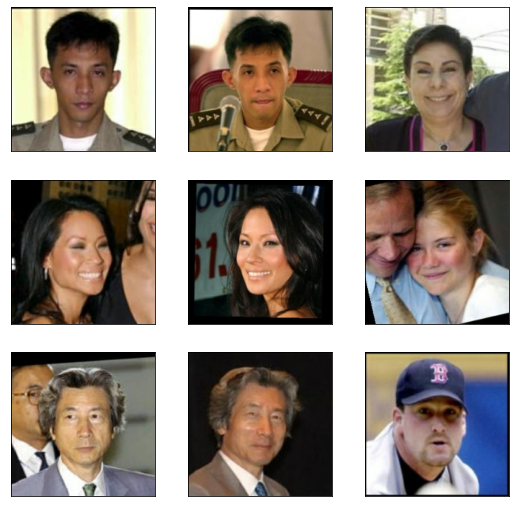

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

        
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

##Se utiliza una red prentrenado y se hace tranferencia de conocimiento, el vector de caracteristicas tiene dimension de 256

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

"""base_cnn = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=target_shape + (3,))"""

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

##Creacion del modelo

In [ ]:
siamese_model = SiameseModel(siamese_network)

##Entrenamiento del model

In [ ]:
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
25/25 [==============================] - 22s 605ms/step - loss: 0.1782 - val_loss: 0.1454
Epoch 2/100
25/25 [==============================] - 13s 517ms/step - loss: 0.1780 - val_loss: 0.1334
Epoch 3/100
25/25 [==============================] - 13s 515ms/step - loss: 0.1312 - val_loss: 0.1341
Epoch 4/100
25/25 [==============================] - 13s 514ms/step - loss: 0.1400 - val_loss: 0.1030
Epoch 5/100
25/25 [==============================] - 13s 513ms/step - loss: 0.1235 - val_loss: 0.1348
Epoch 6/100
25/25 [==============================] - 13s 508ms/step - loss: 0.1290 - val_loss: 0.1126
Epoch 7/100
25/25 [==============================] - 13s 513ms/step - loss: 0.1206 - val_loss: 0.0992
Epoch 8/100
25/25 [==============================] - 13s 514ms/step - loss: 0.1191 - val_loss: 0.1140
Epoch 9/100
25/25 [==============================] - 13s 517ms/step - loss: 0.1176 - val_loss: 0.0804
Epoch 10/100
25/25 [==============================] - 13s 517ms/step - loss: 0.114

In [ ]:
embedding.save('/content/drive/MyDrive/Grupo_investigacion/my_model3.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('/content/drive/MyDrive/Grupo_investigacion/my_model3.h5')

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Grupo_investigacion/Images_misma_carpeta.rar", outdir='/')

patool: Extracting /content/drive/MyDrive/Grupo_investigacion/Images_misma_carpeta.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/Grupo_investigacion/Images_misma_carpeta.rar
patool:     with cwd='/'
patool: ... /content/drive/MyDrive/Grupo_investigacion/Images_misma_carpeta.rar extracted to `/'.


'/'

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt

image_path = ["/Images misma carpeta/"]
#Esta carpeta hay que crearla
newFolder = "/Imagene/" 


def save_faces(cascade, imgname, image_path):
  # uses the casca Haar cascade to isolate the
  # face from an image.
  img = cv2.imread(os.path.join(image_path, imgname))
  celebrity = imgname
  for i, face in enumerate(cascade.detectMultiScale(img)):

      x, y, w, h = face
      sub_face = img[y:y + h, x:x + w]
      resized_image = cv2.resize(sub_face, (224, 224))
      name = celebrity + str(face[0]) +'.jpg'
      plt.imshow(resized_image)
      plt.show()
      cv2.imwrite(os.path.join(newFolder,name), resized_image)
      #print(os.path.join(newFolder,name))
  

face_cascade = "/content/drive/MyDrive/Grupo_investigacion/haarcascade_frontalface_default.xml"
cascade = cv2.CascadeClassifier(face_cascade)
# Iterate through files
for path in image_path:
  for f in [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]:
    print(os.path.join(path, f))
    save_faces(cascade, f,path)

In [ ]:
from keras.preprocessing import image
Names = []
attributes = []
path = "/Images misma carpeta/"
for f in [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]:
  img = preprocess_image(f)
  # convert image to numpy array
  x = image.img_to_array(img)
  # the image is now in an array of shape (3, 200, 200) 
  # need to expand it to (1, 3, 200, 200) as it's expecting a list
  x = np.expand_dims(x, axis=0)
  # extract the features
  Names.append(f)
  attributes.append(embedding(x)[0])

In [ ]:
x = np.asarray(attributes)
y = np.asarray(Names)

In [ ]:
from sklearn.manifold import TSNE

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 5))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x)    
newy = [''.join(i for i in stri if not i.isdigit()) for stri in y]
labelss = [stri.rsplit( ".", 1 )[ 0 ] for stri in newy]

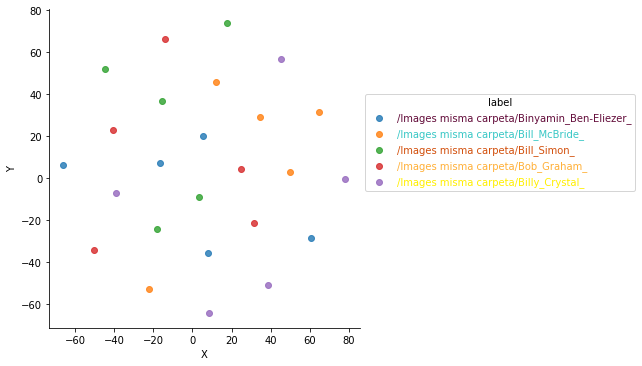

In [ ]:
import pandas as pd
import seaborn as sns

scatterDF =  pd.DataFrame(
    {'X': train_tsne_embeds[:,0],
     'Y': train_tsne_embeds[:,1],
     'Label': labelss
    })

customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139',"#FFF000"]

facet = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', 
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)


#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text,color = customPalette[i])

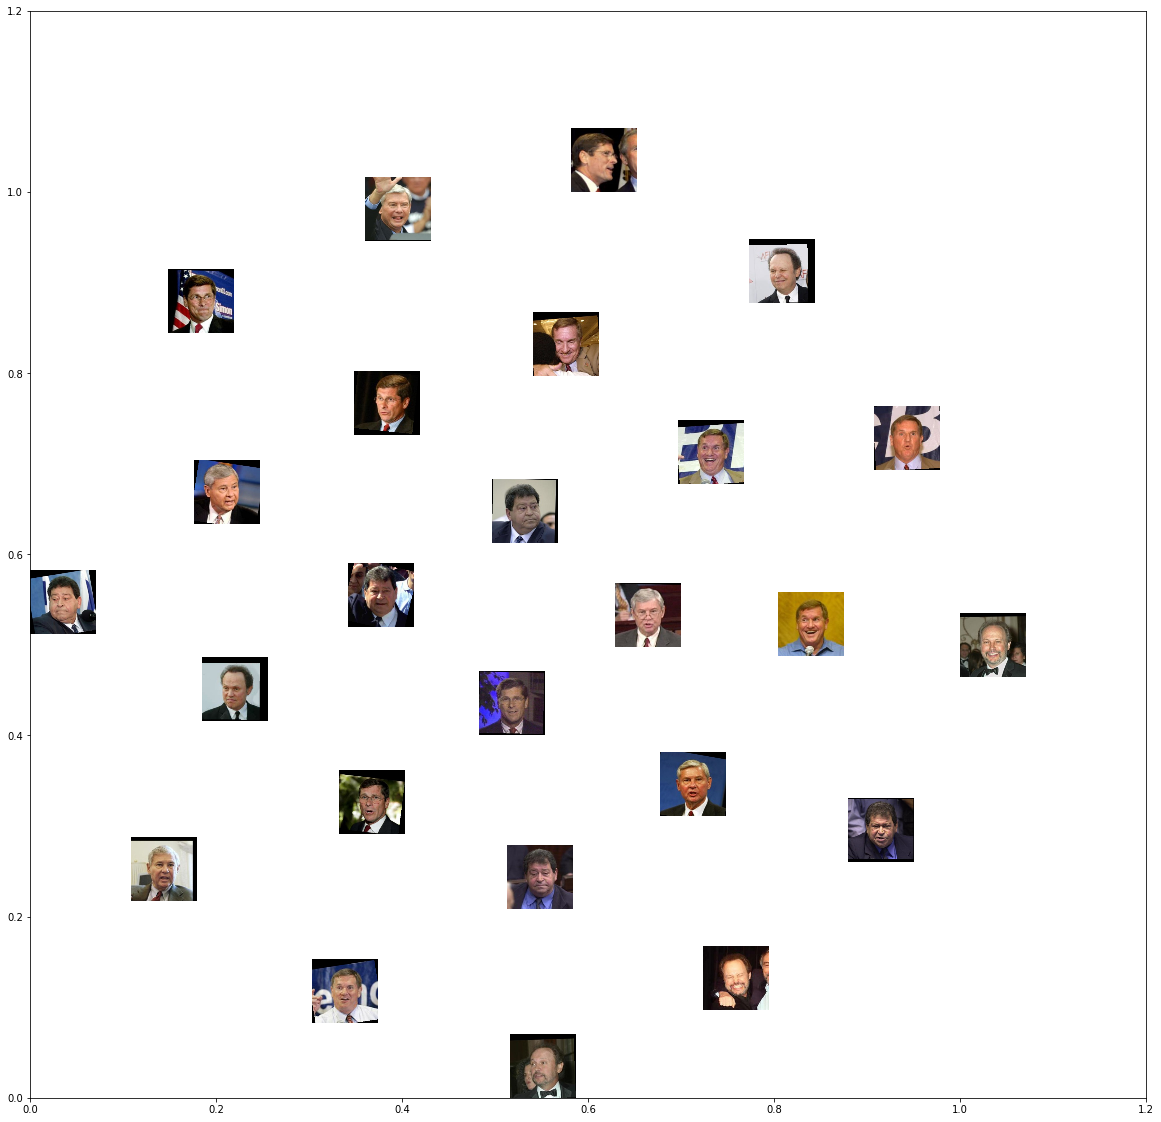

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

path = "/Images misma carpeta/"
all_paths = []
for f in [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]:
  all_paths.append(os.path.join(path, f))
  
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
  
  
norm1 = NormalizeData(train_tsne_embeds[:,0])
norm2 = NormalizeData(train_tsne_embeds[:,1])
  
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
for i in range(len(train_tsne_embeds)):
  bb = Bbox.from_bounds(norm1[i], norm2[i], 0.07, 0.07)
  bb2 = TransformedBbox(bb, ax.transData)
  bbox_image = BboxImage(bb2, norm=None, origin=None, clip_on=False)
  bbox_image.set_data(image.load_img(all_paths[i]))
  ax.add_artist(bbox_image)


ax.set_ylim(0,1.2)  
ax.set_xlim(0,1.2) 
ax.set_facecolor((1.0, 1.0, 1.0))
plt.show()